In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time


from datetime import datetime, timedelta

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, LSTM
from keras.losses import binary_crossentropy, mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['marketdata_sample.csv', 'news_sample.csv']


In [2]:
# Custom module kaggle.competitions.twosigmanews
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [3]:
# Import data
(market_train_df, news_train_df) = env.get_training_data()
del news_train_df
market_train_df['date'] = market_train_df['time'].dt.strftime('%Y-%m-%d')

In [4]:
#market_train_df=market_train_df.loc[market_train_df['time']>"2010-01-01",:]


## Cleaning Market data

There are various problems in market data. 
1. There seem to be some erroneous opening prices (max closing price 1578.13 vs max opening price 9998.99)
2. There is one asset that has two asset codes: "TW.N" and "WW.N", where the last one is erroneous.


<br>Used kernel: https://www.kaggle.com/danielson/cleaning-up-market-data-errors-and-stock-splits

In [5]:
market_train_df.describe().round(2)

,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe
count,4.072956e+06,4072956.00,4072956.00,4072956.00,4072956.00,4056976.00,4056968.00,4072956.00,4072956.00,3979946.00,3979902.00,4072956.00,4072956.00
mean,2.665312e+06,39.71,39.71,0.00,0.01,0.00,0.01,0.01,0.01,0.00,0.01,0.01,0.59
std,7.687606e+06,42.29,42.61,0.04,7.08,0.03,6.97,0.09,7.12,0.08,7.29,7.24,0.49
min,0.000000e+00,0.07,0.01,-0.98,-1.00,-1.24,-615.85,-0.98,-1.00,-3.34,-1375.05,-1375.05,0.00
25%,4.657968e+05,17.25,17.25,-0.01,-0.01,-0.01,-0.01,-0.03,-0.03,-0.03,-0.03,-0.03,0.00
50%,9.821000e+05,30.30,30.29,0.00,0.00,-0.00,-0.00,0.01,0.01,0.00,0.00,0.00,1.00
75%,2.403165e+06,49.86,49.85,0.01,0.01,0.01,0.01,0.04,0.04,0.03,0.03,0.03,1.00
max,1.226791e+09,1578.13,9998.99,45.59,9209.00,45.12,8989.21,46.67,9382.00,46.25,9761.34,9761.34,1.00


From previous table, we can see that max open price is 9998.99 and closing price only 1578 - we should look into this. The returnsClosePrevRaw1 column shows us the daily drop or increase in stock price, from max value we get that biggest rise was 45.59 (4559% !!) and min shows that one stock decreased in value almost 100% in one day (-0.978 = -98%).  returnsOpenPrevRaw1 - max 920900%  open price rise in one day. 

In [6]:
# let's have a look on rows, that have more that 70% drop in one day
market_train_df[market_train_df['returnsClosePrevRaw1'] < -.7] 

#We can see that 4 of those have same date - 2016.07.07, let's take closer look on surrounding dates for these assets

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,date
417063,2008-03-17 22:00:00+00:00,BSC.N,Bear Stearns Companies LLC,166719539.0,4.81,3.17,-0.839667,-0.941556,-0.796695,-0.797304,-0.937791,-0.960186,-0.708275,-0.787416,0.657782,1.0,2008-03-17
628662,2008-09-29 22:00:00+00:00,SOV.N,Santander Holdings USA Inc,51012315.0,2.33,8.56,-0.721625,0.094629,-0.292495,0.086408,-0.741111,-0.040359,-0.439192,0.024449,0.101129,1.0,2008-09-29
660654,2008-10-27 22:00:00+00:00,SVNT.O,Savient Pharmaceuticals Inc,15560744.0,3.07,6.55,-0.734888,-0.394080,-0.691611,-0.367091,-0.743525,-0.406165,-0.481849,-0.363624,0.577453,0.0,2008-10-27
866165,2009-04-30 22:00:00+00:00,SQNM.O,Sequenom Inc,88891648.0,3.62,3.32,-0.757210,-0.773688,-0.755917,-0.737863,-0.766150,-0.784276,-0.779298,-0.806992,-0.045161,1.0,2009-04-30
1253302,2010-05-05 22:00:00+00:00,ITMN.O,InterMune Inc,45248164.0,11.38,10.15,-0.749560,-0.787612,-0.721898,-0.552954,-0.748952,-0.778722,-0.548359,-0.520927,0.290792,1.0,2010-05-05
3474114,2015-09-09 22:00:00+00:00,TTPH.O,Tetraphase Pharmaceuticals Inc,23468076.0,9.49,9.64,-0.788075,-0.778340,-0.755343,-0.729875,-0.753826,-0.752821,-0.717449,-0.675231,0.064186,0.0,2015-09-09
3607400,2015-12-28 22:00:00+00:00,CMRX.O,Chimerix Inc,26705567.0,6.62,7.86,-0.813888,-0.778279,-0.811852,-0.773448,-0.812305,-0.780263,-0.794776,-0.784926,-0.163051,0.0,2015-12-28
3847265,2016-07-07 22:00:00+00:00,FLEX.O,Flex Ltd,4481469.0,11.80,11.81,-0.904415,-0.281630,-0.886907,-0.273703,-0.097859,-0.091538,-0.223552,-0.093630,-0.011186,1.0,2016-07-07
3847633,2016-07-07 22:00:00+00:00,MAT.O,Mattel Inc,2091099.0,32.34,32.14,-0.738032,0.492108,-0.731417,0.463413,0.006536,-0.001243,-0.040354,-0.003972,-0.077818,1.0,2016-07-07
3848074,2016-07-07 22:00:00+00:00,SHLD.O,Sears Holdings Corp,497204.0,13.40,13.27,-0.891472,0.501131,-0.875653,0.480682,-0.022611,-0.058865,-0.133526,-0.057434,0.032036,0.0,2016-07-07


In [7]:
someAssetsWithBadData = ['FLEX.O','MAT.O','SHLD.O','ZNGA.O']
someMarketData = market_train_df[(market_train_df['assetCode'].isin(someAssetsWithBadData)) 
                & (market_train_df['time'] >= '2016-07-05')
                & (market_train_df['time'] < '2016-07-08')].sort_values('assetCode')
someMarketData

#From here we get that, all these have similar close value on 6th - 123.45 and 123.47.
# I would have a look on all data between these dates, seems like input error. close-open >=10

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,date
3843668,2016-07-05 22:00:00+00:00,FLEX.O,Flex Ltd,3839393.0,11.66,11.70,-0.010187,-0.005102,-0.000815,-0.003561,-0.101695,-0.090909,-0.103166,-0.097041,-0.247207,1.0,2016-07-05
3845467,2016-07-06 22:00:00+00:00,FLEX.O,Flex Ltd,175451.0,123.45,16.44,9.587479,0.405128,9.482848,0.404713,8.503464,0.254962,8.425788,0.255200,0.087592,1.0,2016-07-06
3847265,2016-07-07 22:00:00+00:00,FLEX.O,Flex Ltd,4481469.0,11.80,11.81,-0.904415,-0.281630,-0.886907,-0.273703,-0.097859,-0.091538,-0.223552,-0.093630,-0.011186,1.0,2016-07-07
3844037,2016-07-05 22:00:00+00:00,MAT.O,Mattel Inc,3333108.0,31.62,31.46,0.002219,0.005433,0.014722,0.008522,-0.024676,-0.019021,-0.027185,-0.029008,0.396756,1.0,2016-07-05
3845835,2016-07-06 22:00:00+00:00,MAT.O,Mattel Inc,56994.0,123.45,21.54,2.904175,-0.315321,2.864919,-0.304480,2.842204,-0.334363,2.812233,-0.334071,-0.069237,1.0,2016-07-06
3847633,2016-07-07 22:00:00+00:00,MAT.O,Mattel Inc,2091099.0,32.34,32.14,-0.738032,0.492108,-0.731417,0.463413,0.006536,-0.001243,-0.040354,-0.003972,-0.077818,1.0,2016-07-07
3844479,2016-07-05 22:00:00+00:00,SHLD.O,Sears Holdings Corp,388228.0,12.98,13.63,-0.065515,0.009630,-0.054871,0.010488,-0.070201,-0.046853,-0.072216,-0.058148,0.541448,0.0,2016-07-05
3846276,2016-07-06 22:00:00+00:00,SHLD.O,Sears Holdings Corp,80940.0,123.47,8.84,8.512327,-0.351431,8.417827,-0.345786,7.781650,-0.370819,7.710716,-0.370630,0.059298,0.0,2016-07-06
3848074,2016-07-07 22:00:00+00:00,SHLD.O,Sears Holdings Corp,497204.0,13.40,13.27,-0.891472,0.501131,-0.875653,0.480682,-0.022611,-0.058865,-0.133526,-0.057434,0.032036,0.0,2016-07-07
3844838,2016-07-05 22:00:00+00:00,ZNGA.O,Zynga Inc,9732445.0,2.65,2.60,0.039216,0.044177,0.048598,0.045064,0.031128,0.044177,0.026816,0.029699,-0.306158,0.0,2016-07-05


In [8]:
#difference between close/open price is more than 10 (change in one day)
someMarketData2 = market_train_df[(market_train_df['time'] >= '2016-07-05') & (market_train_df['time'] < '2016-07-08') 
                                  & (market_train_df['close'] - market_train_df['open'] >=10)].sort_values('assetCode')
AssetsWithBadData=someMarketData2[(someMarketData2['close'] == 123.45)|(someMarketData2['close'] == 123.47)]['assetCode']
someMarketData2

,time,assetCode,assetName,volume,close,open,returnsClosePrevRaw1,returnsOpenPrevRaw1,returnsClosePrevMktres1,returnsOpenPrevMktres1,returnsClosePrevRaw10,returnsOpenPrevRaw10,returnsClosePrevMktres10,returnsOpenPrevMktres10,returnsOpenNextMktres10,universe,date
3844944,2016-07-06 22:00:00+00:00,AMZN.O,Amazon.com Inc,3938249.0,737.61,725.71,0.013061,0.004026,0.008342,0.004942,0.030441,0.013958,0.024262,0.014334,-0.020081,1.0,2016-07-06
3845015,2016-07-06 22:00:00+00:00,BBBY.O,Bed Bath & Beyond Inc,50303.0,123.45,30.68,1.921202,-0.295522,1.897847,-0.291610,1.849065,-0.303044,1.826249,-0.302549,-0.047101,1.0,2016-07-06
3845309,2016-07-06 22:00:00+00:00,DISH.O,DISH Network Corp,87466.0,123.47,63.29,1.430033,0.206903,1.407708,0.208864,1.325673,0.187207,1.295536,0.188725,-0.030583,1.0,2016-07-06
3845467,2016-07-06 22:00:00+00:00,FLEX.O,Flex Ltd,175451.0,123.45,16.44,9.587479,0.405128,9.482848,0.404713,8.503464,0.254962,8.425788,0.255200,0.087592,1.0,2016-07-06
3845835,2016-07-06 22:00:00+00:00,MAT.O,Mattel Inc,56994.0,123.45,21.54,2.904175,-0.315321,2.864919,-0.304480,2.842204,-0.334363,2.812233,-0.334071,-0.069237,1.0,2016-07-06
3845946,2016-07-06 22:00:00+00:00,NDAQ.O,Nasdaq Inc,113350.0,123.47,71.51,0.911596,0.122254,0.897776,0.122543,0.960775,0.135801,0.946862,0.136170,0.001852,1.0,2016-07-06
3846067,2016-07-06 22:00:00+00:00,PCAR.O,Paccar Inc,63374.0,123.45,66.41,1.445523,0.285521,1.420271,0.288671,1.261818,0.218979,1.242209,0.219653,0.030409,1.0,2016-07-06
3844271,2016-07-05 22:00:00+00:00,PCLN.O,Booking Holdings Inc,568815.0,1275.03,1259.56,0.006044,0.008447,0.021392,0.010721,-0.049875,-0.048412,-0.054914,-0.064660,-0.023824,1.0,2016-07-05
3846069,2016-07-06 22:00:00+00:00,PCLN.O,Booking Holdings Inc,562266.0,1292.04,1269.86,0.013341,0.008177,0.001566,0.013722,-0.037981,-0.055410,-0.047257,-0.054742,-0.018944,1.0,2016-07-06
3846151,2016-07-06 22:00:00+00:00,PZZA.O,Papa John's International Inc,25050.0,123.45,71.89,0.817580,0.056429,0.805544,0.056785,0.857229,0.076198,0.847870,0.076377,0.054807,0.0,2016-07-06


Turns out there are 9 assets with same error, next we will need to fix these errors. 


Assets: BBBY.O, DISH.O, FLEX.O, MAT.O, NDAQ.O, PCAR.O, PZZA.O, SHLD.O, ZNGA.O

#### Fixing 2016-07-06 errors

In [9]:
def sampleAssetData(assetCode, date, numDays):
    d = datetime.strptime(date,'%Y-%m-%d')
    start = d - timedelta(days=numDays)
    end = d + timedelta(days=numDays)
    return market_train_df[(market_train_df['assetCode'] == assetCode)
                             & (market_train_df['time'] >= start.strftime('%Y-%m-%d'))
                             & (market_train_df['time'] <= end.strftime('%Y-%m-%d'))].copy()

def updateRawReturns(assetData, indices):
    rowsToUpdate1 = assetData[(assetData.index >= indices[0][0]) & (assetData.index <= indices[0][1])]
    for index, row in rowsToUpdate1.iterrows():
        market_train_df.loc[[index],['returnsClosePrevRaw1']] = assetData['close'].pct_change()
        market_train_df.loc[[index],['returnsOpenPrevRaw1']] = assetData['open'].pct_change()
    rowsToUpdate2 = assetData[(assetData.index >= indices[1][0]) & (assetData.index <= indices[1][1])]
    for index, row in rowsToUpdate2.iterrows():
        market_train_df.loc[[index],['returnsClosePrevRaw10']] = assetData['close'].pct_change(periods=10)
        market_train_df.loc[[index],['returnsOpenPrevRaw10']] = assetData['open'].pct_change(periods=10)
        
def estimateMktresReturn(sampleData, mktresCol, index):
    sampleData['ones'] = 1
    sampleData.dropna(inplace=True)
    rawCol = mktresCol.replace('Mktres','Raw')
    A = sampleData[[rawCol,'ones']]
    y = sampleData[mktresCol]
    m, c = np.linalg.lstsq(A,y,rcond=-1)[0]
    return c + m * market_train_df.loc[index,rawCol]

def updateMktresReturns(assetCode, assetData, indices):
    # update range of values for returnsClosePrevMktres1 & returnsOpenPrevMktres1
    sample1 = assetData[(assetData.index < indices[2][0]) | (assetData.index > indices[2][1])]
    rowsToUpdate1 = assetData[(assetData.index >= indices[2][0]) & (assetData.index <= indices[2][1])]
    for index, row in rowsToUpdate1.iterrows():
        market_train_df.loc[[index],['returnsClosePrevMktres1']] = estimateMktresReturn(sample1,'returnsClosePrevMktres1',index)
        market_train_df.loc[[index],['returnsOpenPrevMktres1']] = estimateMktresReturn(sample1,'returnsOpenPrevMktres1',index)
    # update range of values for returnsClosePrevMktres10 & returnsOpenPrevMktres10
    sample2 = assetData[(assetData.index < indices[3][0]) | (assetData.index > indices[3][1])]
    rowsToUpdate2 = assetData[(assetData.index >= indices[3][0]) & (assetData.index <= indices[3][1])]
    l = []
    for index, row in rowsToUpdate2.iterrows():
        market_train_df.loc[[index],['returnsClosePrevMktres10']] = estimateMktresReturn(sample2,'returnsClosePrevMktres10',index)
        est = estimateMktresReturn(sample2,'returnsOpenPrevMktres10',index)
        l.append(est)
        market_train_df.loc[[index],['returnsOpenPrevMktres10']] = est
    # update range of values for returnsOpenNextMktres10
    rowsToUpdate3 = assetData[(assetData.index >= indices[4][0]) & (assetData.index <= indices[4][1])]
    i = 0
    for index, row in rowsToUpdate3.iterrows():
        market_train_df.loc[[index],['returnsOpenNextMktres10']] = l[i]
        i += 1
        
def fixBadReturnData(assetCode, badDate, badIndex, badReturnDataRanges, dayWindow):
    # store copy of bad data window
    badDataWindow = sampleAssetData(assetCode,badDate,dayWindow)
    badDataWindow.reset_index(inplace=True)
    # store indices needed to update raw and mktres return data
    newIdx = badDataWindow[badDataWindow['index'] == badIndex].index[0]
    indices = [
        # range of bad data for... returnsClosePrevRaw1 & returnsOpenPrevRaw1
        [badIndex,badDataWindow.loc[newIdx+badReturnDataRanges[0],'index']],
        # returnsClosePrevRaw10 & returnsOpenPrevRaw10
        [badIndex,badDataWindow.loc[newIdx+badReturnDataRanges[1],'index']],
        # returnsClosePrevMktres1 & returnsOpenPrevMktres1
        [badIndex,badDataWindow.loc[newIdx+badReturnDataRanges[2],'index']],
        # returnsClosePrevMktres10 & returnsOpenPrevMktres10
        [badIndex,badDataWindow.loc[newIdx+badReturnDataRanges[3],'index']],
        # returnsOpenNextMktres10
        [badDataWindow.loc[newIdx+badReturnDataRanges[4],'index'],badDataWindow.loc[newIdx+badReturnDataRanges[5],'index']]
    ]
    badDataWindow.set_index('index',inplace=True)
    # correct bad raw return data
    updateRawReturns(badDataWindow,indices)
    # estimate affected mktres return data
    updateMktresReturns(assetCode,badDataWindow,indices)

In [10]:
# dropping ZNGA.O data in May-Aug 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'ZNGA.O')
                                  & (market_train_df['time'] >= '2016-05-21')
                                  & (market_train_df['time'] <= '2016-08-21'))]

In [11]:
# dropping FLEX.O data in May-Aug 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'FLEX.O')
                                  & (market_train_df['time'] >= '2016-05-21')
                                  & (market_train_df['time'] <= '2016-08-21'))]

In [12]:
# dropping SHLD.O data in May-Aug 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'SHLD.O')
                                  & (market_train_df['time'] >= '2016-05-21')
                                  & (market_train_df['time'] <= '2016-08-21'))]

In [13]:
# dropping MAT.O data in May-Aug 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'MAT.O')
                                  & (market_train_df['time'] >= '2016-05-21')
                                  & (market_train_df['time'] <= '2016-08-21'))]

In [14]:
market_train_df.shape

(4072704, 17)

In [15]:
# dropping BBBY.O data in May-Aug 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'BBBY.O')
                                  & (market_train_df['time'] >= '2016-05-21')
                                  & (market_train_df['time'] <= '2016-08-21'))]

In [16]:
# dropping DISH.O data in May-Aug 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'DISH.O')
                                  & (market_train_df['time'] >= '2016-05-21')
                                  & (market_train_df['time'] <= '2016-08-21'))]

In [17]:
# dropping NDAQ.O data in May-Aug 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'NDAQ.O')
                                  & (market_train_df['time'] >= '2016-05-21')
                                  & (market_train_df['time'] <= '2016-08-21'))]

In [18]:
# dropping PCAR.O data in May-Aug 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'PCAR.O')
                                  & (market_train_df['time'] >= '2016-05-21')
                                  & (market_train_df['time'] <= '2016-08-21'))]

In [19]:
# dropping PZZA.O data in May-Aug 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'PZZA.O')
                                  & (market_train_df['time'] >= '2016-05-21')
                                  & (market_train_df['time'] <= '2016-08-21'))]

In [20]:
market_train_df.shape

(4072389, 17)

#### There is one asset that has two asset codes: "TW.N" and "WW.N", where the last one is erroneous.

In [21]:
# Fix asset code "WW.N" and remove the observations with erroneous return data
market_train_df.loc[market_train_df['assetCode'] == 'WW.N','assetCode'] = 'TW.N'
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'TW.N')
                                  & (market_train_df['time'] >= '2009-12-16')
                                  & (market_train_df['time'] < '2010-01-08'))]

In [22]:
# dropping Qorvo data through 2015-02-13
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'QRVO.O')
                                  & (market_train_df['time'] < '2015-02-14'))]

In [23]:
# bad return data for PGN.N from 2011-10-19 to 2012-03-28
assetCode = 'PGN.N'
# fix first section of incorrect raw returns
badDate1 = '2011-12-23'
badIndex1 = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate1)].index[0]
dayWindow1 = 20
badReturnDataRanges1 = [0,9]
badDataWindow1 = sampleAssetData(assetCode,badDate1,dayWindow1)
badDataWindow1.reset_index(inplace=True)
newIdx1 = badDataWindow1[badDataWindow1['index'] == badIndex1].index[0]
rawIndices1 = [
    [badIndex1,badDataWindow1.loc[newIdx1+badReturnDataRanges1[0],'index']],
    [badIndex1,badDataWindow1.loc[newIdx1+badReturnDataRanges1[1],'index']]
]
badDataWindow1.set_index('index',inplace=True)
updateRawReturns(badDataWindow1,rawIndices1)
# fix second section of incorrect raw returns
badDate2 = '2012-02-15'
badIndex2 = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate2)].index[0]
dayWindow2 = 20
badReturnDataRanges2 = [0,9]
badDataWindow2 = sampleAssetData(assetCode,badDate2,dayWindow2)
badDataWindow2.reset_index(inplace=True)
newIdx2 = badDataWindow2[badDataWindow2['index'] == badIndex2].index[0]
rawIndices2 = [
    [badIndex2,badDataWindow2.loc[newIdx2+badReturnDataRanges2[0],'index']],
    [badIndex2,badDataWindow2.loc[newIdx2+badReturnDataRanges2[1],'index']]
]
badDataWindow2.set_index('index',inplace=True)
updateRawReturns(badDataWindow2,rawIndices2)
# fix mktres returns
badDate3 = '2012-01-09'
badIndex3 = market_train_df[(market_train_df['assetCode'] == assetCode) & (market_train_df['date'] == badDate3)].index[0]
dayWindow3 = 120
badReturnDataRanges3 = [-44,46,55,-55,44]
badDataWindow3 = sampleAssetData(assetCode,badDate3,dayWindow3)
badDataWindow3.reset_index(inplace=True)
newIdx3 = badDataWindow3[badDataWindow3['index'] == badIndex3].index[0]
indices3 = [[],[],
    [badDataWindow3.loc[newIdx3+badReturnDataRanges3[0],'index'],badDataWindow3.loc[newIdx3+badReturnDataRanges3[1],'index']],
    [badDataWindow3.loc[newIdx3+badReturnDataRanges3[0],'index'],badDataWindow3.loc[newIdx3+badReturnDataRanges3[2],'index']],
    [badDataWindow3.loc[newIdx3+badReturnDataRanges3[3],'index'],badDataWindow3.loc[newIdx3+badReturnDataRanges3[4],'index']]
]
badDataWindow3.set_index('index',inplace=True)
updateMktresReturns(assetCode,badDataWindow3,indices3)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_

In [24]:
# dropping TECD.O data in Feb-May 2015
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'TECD.O')
                                  & (market_train_df['time'] >= '2015-01-30')
                                  & (market_train_df['time'] <= '2015-04-30'))]

In [25]:
# dropping EBR.N data in Oct 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'EBR.N')
                                  & (market_train_df['time'] >= '2016-10-01'))]

In [26]:
# dropping HGSI.O data in Feb and Mar 2016
market_train_df = market_train_df[~((market_train_df['assetCode'] == 'HGSI.O')
                                  & (market_train_df['time'] < '2009-04-01'))]

In [27]:
market_train_df.shape

(4071802, 17)

## Creating Model
Got most of it from https://www.kaggle.com/christofhenkel/market-data-nn-baseline

In [28]:
cat_cols = ['assetCode']
num_cols = ['volume', 'close', 'open', 'returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevMktres1',
            'returnsOpenPrevMktres1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10', 'returnsClosePrevMktres10',
            'returnsOpenPrevMktres10']

train_indices, val_indices = train_test_split(market_train_df.index.values,test_size=0.25, random_state=20)

### Handling categorical values

In [29]:
def encode(encoder, x):
    len_encoder = len(encoder)
    try:
        id = encoder[x]
    except KeyError:
        id = len_encoder
    return id

encoders = [{} for cat in cat_cols]


for i, cat in enumerate(cat_cols):
    print('encoding %s ...' % cat, end=' ')
    encoders[i] = {l: id for id, l in enumerate(market_train_df.loc[train_indices, cat].astype(str).unique())}
    market_train_df[cat] = market_train_df[cat].astype(str).apply(lambda x: encode(encoders[i], x))
    print('Done')

embed_sizes = [len(encoder) + 1 for encoder in encoders] #+1 for possible unknown assets

encoding assetCode ... Done


### Normalizing numerical values

In [30]:
market_train_df[num_cols] = market_train_df[num_cols].fillna(0)
print('scaling numerical columns')

scaler = StandardScaler()

scaler = StandardScaler()
market_train_df[num_cols] = scaler.fit_transform(market_train_df[num_cols])

scaling numerical columns


In [31]:
categorical_inputs = []
for cat in cat_cols:
    categorical_inputs.append(Input(shape=[1], name=cat))

categorical_embeddings = []
for i, cat in enumerate(cat_cols):
    categorical_embeddings.append(Embedding(embed_sizes[i], 10)(categorical_inputs[i]))

#categorical_logits = Concatenate()([Flatten()(cat_emb) for cat_emb in categorical_embeddings])
categorical_logits = Flatten()(categorical_embeddings[0])
categorical_logits = Dense(32,activation='tanh')(categorical_logits)

numerical_inputs = Input(shape=(11,), name='num')
numerical_logits = numerical_inputs
numerical_logits = BatchNormalization()(numerical_logits)


#numerical_logits = LSTM(150, input_shape=numerical_logits.shape, return_sequences=False)(numerical logits)
#numerical_logits = LSTM(32, activation='tanh', recurrent_activation='hard_sigmoid')(numerical_logits)
numerical_logits = Dense(128,activation='tanh')(numerical_logits)
numerical_logits = Dense(64,activation='tanh')(numerical_logits)

logits = Concatenate()([numerical_logits,categorical_logits])
logits = Dense(64,activation='tanh')(logits)
out = Dense(1, activation='tanh')(logits)

model = Model(inputs = categorical_inputs + [numerical_inputs], outputs=out)
#model.add(LSTM(hidden_size, return_sequences=True)
model.compile(optimizer='adam',loss=binary_crossentropy)

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
num (InputLayer)                (None, 11)           0                                            
__________________________________________________________________________________________________
assetCode (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 11)           44          num[0][0]                        
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 10)        37750       assetCode[0][0]                  
__________________________________________________________________________________________________
dense_2 (D

In [33]:
def get_input(market_train, indices):
    X_num = market_train_df.loc[indices, num_cols].values
    X = {'num':X_num}
    for cat in cat_cols:
        X[cat] = market_train_df.loc[indices, cat_cols].values
    y = (market_train_df.loc[indices,'returnsOpenNextMktres10'] >= 0).values
    r = market_train_df.loc[indices,'returnsOpenNextMktres10'].values
    u = market_train_df.loc[indices, 'universe']
    d = market_train_df.loc[indices, 'time'].dt.date
    return X,y,r,u,d

# r, u and d are used to calculate the scoring metric
X_train,y_train,r_train,u_train,d_train = get_input(market_train_df, train_indices)
X_valid,y_valid,r_valid,u_valid,d_valid = get_input(market_train_df, val_indices)

In [34]:
%%time
check_point = ModelCheckpoint('model.hdf5',verbose=True, save_best_only=True)
early_stop = EarlyStopping(patience=5,verbose=True)
model.fit(X_train,y_train.astype(int),
          validation_data=(X_valid,y_valid.astype(int)),
          epochs=2,
          verbose=True,
          callbacks=[early_stop,check_point]) 

Train on 3053851 samples, validate on 1017951 samples
Epoch 1/2
3053851/3053851 [==============================] - 195s 64us/step - loss: 0.6883 - val_loss: 0.6857

Epoch 00001: val_loss improved from inf to 0.68575, saving model to model.hdf5
Epoch 2/2
3053851/3053851 [==============================] - 193s 63us/step - loss: 0.6848 - val_loss: 0.6853

Epoch 00002: val_loss improved from 0.68575 to 0.68530, saving model to model.hdf5
CPU times: user 13min 14s, sys: 1min 35s, total: 14min 50s
Wall time: 6min 28s


0.5509852635342959


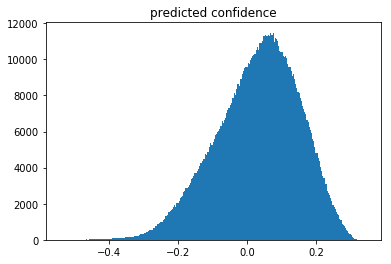

In [35]:
# distribution of confidence that will be used as submission
model.load_weights('model.hdf5')
confidence_valid = model.predict(X_valid)[:,0]*2 -1
print(accuracy_score(confidence_valid>0,y_valid))
plt.hist(confidence_valid, bins='auto')
plt.title("predicted confidence")
plt.show()

In [36]:
# calculation of actual metric that is used to calculate final score
r_valid = r_valid.clip(-1,1) # get rid of outliers. Where do they come from??
x_t_i = confidence_valid * r_valid * u_valid
data = {'day' : d_valid, 'x_t_i' : x_t_i}
df = pd.DataFrame(data)
x_t = df.groupby('day').sum().values.flatten()
mean = np.mean(x_t)
std = np.std(x_t)
score_valid = mean / std
print(score_valid)

0.7535177647326675


## Predicting

In [37]:
days = env.get_prediction_days()

In [38]:
n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
predicted_confidences = np.array([])
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    print(n_days,end=' ')
    
    t = time.time()

    market_obs_df['assetCode_encoded'] = market_obs_df[cat].astype(str).apply(lambda x: encode(encoders[i], x))

    market_obs_df[num_cols] = market_obs_df[num_cols].fillna(0)
    market_obs_df[num_cols] = scaler.transform(market_obs_df[num_cols])
    X_num_test = market_obs_df[num_cols].values
    X_test = {'num':X_num_test}
    X_test['assetCode'] = market_obs_df['assetCode_encoded'].values
    
    prep_time += time.time() - t
    
    t = time.time()
    market_prediction = model.predict(X_test)[:,0]*2 -1
    predicted_confidences = np.concatenate((predicted_confidences, market_prediction))
    prediction_time += time.time() -t
    
    t = time.time()
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':market_prediction})
    # insert predictions to template
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t

env.write_submission_file()
total = prep_time + prediction_time + packaging_time
print(f'Preparing Data: {prep_time:.2f}s')
print(f'Making Predictions: {prediction_time:.2f}s')
print(f'Packing: {packaging_time:.2f}s')
print(f'Total: {total:.2f}s')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

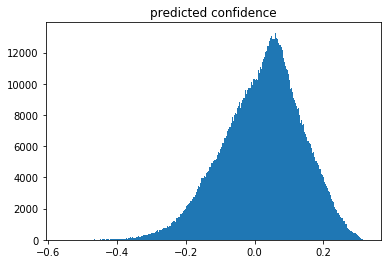

In [39]:
# distribution of confidence as a sanity check: they should be distributed as above
plt.hist(predicted_confidences, bins='auto')
plt.title("predicted confidence")
plt.show()